# **Workshop: From electrons to phase diagrams**

# Day 2: Validation of the potentials

Once we have the fitted potentials, it is necessary to validate them in order to assess their quality with respect to applications.

In this exercise, we use the fitted potentials and perform some basic calculations.

## Import the fitted potentials for Li-Al (from earlier excercise)

The same directory contains a `helper.py` file which among other things, also contains the necessary specifications of each of the potentials that we will use today. Individual potentials are descrbed in the LAMMPS format as:
```
pot_eam = pd.DataFrame({
    'Name': ['LiAl_eam'],
    'Filename': [["../potentials/AlLi.eam.fs")]],
    'Model': ["EAM"],
    'Species': [['Li', 'Al']],
    'Config': [['pair_style eam/fs\n', 'pair_coeff * * AlLi.eam.fs Li Al\n']]
})

```
A list of such DataFrames describing the potentials is saved in a list called `potentials_list`. We import the list as:

In [1]:
from helper import potentials_list

# potentials_list = [potentials_list[1]]

# display the first element in the list
# which is an EAM potential
potentials_list[0]

,Name,Filename,Model,Species,Config
0,LiAl_eam,[/home/jovyan/workshop_preparation/potentials/...,EAM,"[Li, Al]","[pair_style eam/fs\n, pair_coeff * * AlLi.eam...."


### Import other important modules

In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import time
from helper import get_clean_project_name
from pyiron_atomistics import Project
from pyiron import pyiron_to_ase
import pyiron_gpl

# save start time to record runtime of the notebook
time_start =  time.time()
time_start

1654611873.989647

### Create a new project to perform validation calculations

It is useful to create a new project directory for every kind of calculation. Pyiron will automatically create subdirectories for each potential and property we calculate. 

In [3]:
pr = Project("validation_LiAl")

# remove earlier jobs
pr.remove_jobs(silently=True, recursive=True)

  0%|          | 0/551 [00:00<?, ?it/s]

### Define the important pases to consider for validation

We construct a python dictionary `struct_dict` which contains a description of all the important phases that we want to consider for this exercise. The descriptions given in the dictionary will be later used by Pyiron to generate or read the structural configurations for the respective phases.

For unary phases, we provide an initial guess for the lattice parameter and use pyiron to generate the structural prototype.

For binary phases, we provide a phase name and an additional dictionary `fl_dict` which maps the phase name to a `.cif` file saved in a subdirectory. Pyiron will use this information to read the respective configurations from the file.

In [4]:
struct_dict = dict()
struct_dict["Al"] = dict()
struct_dict["Al"]["s_murn"] = ["fcc","bcc"]
struct_dict["Al"]["a"] = 4.04

struct_dict["Li"] = dict()
struct_dict["Li"]["s_murn"] = ["bcc","fcc"]
struct_dict["Li"]["a"] = 3.5




struct_dict["Li2Al2"] = dict()
struct_dict["Li2Al2"]["s_murn"] = ["Li2Al2_cubic"]
# struct_dict["Li2Al2"]["a"] = 3.7

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_tetragonal"]
# struct_dict["LiAl3"]["a"] = 3.7

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_cubic"]
# struct_dict["LiAl3"]["a"] = 3.7

struct_dict["Li9Al4"] = dict()
struct_dict["Li9Al4"]["s_murn"] = ["Li9Al4_monoclinic"]
# struct_dict["Li9Al4"]["a"] = 3.7

struct_dict["Li3Al2"] = dict()
struct_dict["Li3Al2"]["s_murn"] = ["Li3Al2_trigonal"]
# struct_dict["Li3Al2"]["a"] = 3.7

struct_dict["Li4Al4"] = dict()
struct_dict["Li4Al4"]["s_murn"] = ["Li4Al4_cubic"]

struct_dict

{'Al': {'s_murn': ['fcc', 'bcc'], 'a': 4.04},
 'Li': {'s_murn': ['bcc', 'fcc'], 'a': 3.5},
 'Li2Al2': {'s_murn': ['Li2Al2_cubic']},
 'LiAl3': {'s_murn': ['LiAl3_cubic']},
 'Li9Al4': {'s_murn': ['Li9Al4_monoclinic']},
 'Li3Al2': {'s_murn': ['Li3Al2_trigonal']},
 'Li4Al4': {'s_murn': ['Li4Al4_cubic']}}

a dictionary is described to map the binary phases to their file locations

In [5]:
fl_dict = {"Li2Al2_cubic": "mp_structures/LiAl_mp-1067_primitive.cif",
           "LiAl3_tetragonal":"mp_structures/LiAl3_mp-975906_primitive.cif",
           "LiAl3_cubic":"mp_structures/LiAl3_mp-10890_primitive.cif",
           "Li9Al4_monoclinic":"mp_structures/Li9Al4_mp-568404_primitive.cif",
           "Li3Al2_trigonal":"mp_structures/Al2Li3-6021.cif",
           "Li4Al4_cubic":"mp_structures/LiAl_mp-1079240_primitive.cif"}

## (a) Ground state: E-V curves

Using a series of nested `for` loops, we calculate the murnaghan EV-curves using all three potentials for all the defined structures.

We loop over:
 - All the potentials defined in `potentials_list` and name the project according to the potential
   - All the chemical formulae defined in the keys of `struct_dict`
     - All phases defined for a given chemical formula
     
Within the loops, the first step is to get the structure basis on which we will perform the calculations. 

- For unary phases, we use the pyiron function `pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])` 
- For binary structures, we read the basis using `pr.create.structure.ase.read(fl_path)` with the `fl_path` given by `fl_dict` defined earlier.

Once the structure and potential is defined as part of the pr_job, we run two calculations:
- `job_relax` to relax the structure to the ground state
- `murn_job` to calculate the energies in a small volume range around the equilibrium

As the calculations are being performed, the status(s) of each calculation is printed. If a job is already calculated, the calculations are not re-run but rather re-read from the saved data.

In [6]:
for pot in potentials_list:
    with pr.open(get_clean_project_name(pot)) as pr_pot:
        for compound, compound_dict in struct_dict.items():
            for crys_structure in compound_dict["s_murn"]:
                
                # Relax structure
                if crys_structure in ["fcc","bcc"]:
                    basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])
                else:
                    basis = pr.create.structure.ase.read(fl_dict[crys_structure])
                job_relax = pr_pot.create_job(pr_pot.job_type.Lammps, f"{compound}_{crys_structure}_relax", delete_existing_job=True)

                job_relax.structure = basis
                job_relax.potential = pot
                job_relax.calc_minimize(pressure=0)
                job_relax.run()
                
                # Murnaghan
                job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{compound}_{crys_structure}")
                job_ref.structure = job_relax.get_structure(-1)
                job_ref.potential = pot
                job_ref.calc_minimize()
                
                murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, f"murn_job_{compound}_{crys_structure}")
                murn_job.input["vol_range"] = 0.1
                murn_job.run()

The job Al_fcc_relax was saved and received the ID: 1139
The job murn_job_Al_fcc was saved and received the ID: 1140
The job murn_job_Al_fcc_0_9 was saved and received the ID: 1141
The job murn_job_Al_fcc_0_92 was saved and received the ID: 1142
The job murn_job_Al_fcc_0_94 was saved and received the ID: 1143
The job murn_job_Al_fcc_0_96 was saved and received the ID: 1144
The job murn_job_Al_fcc_0_98 was saved and received the ID: 1145
The job murn_job_Al_fcc_1_0 was saved and received the ID: 1146
The job murn_job_Al_fcc_1_02 was saved and received the ID: 1147
The job murn_job_Al_fcc_1_04 was saved and received the ID: 1148
The job murn_job_Al_fcc_1_06 was saved and received the ID: 1149
The job murn_job_Al_fcc_1_08 was saved and received the ID: 1150
The job murn_job_Al_fcc_1_1 was saved and received the ID: 1151
The job Al_bcc_relax was saved and received the ID: 1152
The job murn_job_Al_bcc was saved and received the ID: 1153
The job murn_job_Al_bcc_0_9 was saved and received the

One can display the technical details of all submitted jobs using `pr.job_table()` below.

In [7]:
# pr.job_table()

In order to get read useful results from the completed calculations (eq_energy, eq_volume, etc), it is useful to define the following functions

In [8]:
# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path.project.path.split("/")[-3]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

def get_ase_atoms(job_path):
    return pyiron_to_ase(job_path.structure).copy()


def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

Using the functions defined above, one can now define a `pd.DataFrame` containing all useful results

In [9]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["ase_atoms"] = get_ase_atoms
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()

data_murn = table.get_dataframe()
data_murn["phase"] = data_murn.compound + "_" + data_murn.crystal_structure
data_murn

The job table_murn was saved and received the ID: 1490


Loading and filtering jobs:   0%|          | 0/27 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/27 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyiron_base/table/datamining.py:620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['potential', 'ase_atoms', 'compound', 'crystal_structure'], dtype='object')]

  self.pyiron_table._df.to_hdf(


,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
3,1179,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic
6,1218,LiAl_eam,"(Atom('Li', [4.9874611628416465, 1.0099045365192156, 0.8188840806477526], index=0), Atom('Li', [3.1237816780987666, 1.455730745331952, 2.673723152073369], index=1), Atom('Li', [-3.4421956688209843...",Li9Al4,monoclinic,13.023701,190.504374,53.125276,-28.970054,13,Li9Al4_monoclinic
7,1231,LiAl_eam,"(Atom('Al', [2.1548001975659234, 1.244075358781918, 1.861784175000869], index=0), Atom('Al', [-2.154798282819334, 3.732223313213554, 2.6646760238080542], index=1), Atom('Li', [8.560563403365654e-0...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal
8,1244,LiAl_eam,"(Atom('Li', [2.142967147985671, 1.2372426587287435, 7.662120717536293], index=0), Atom('Li', [-8.783761113500244e-10, 2.4744853189563414, 0.5913679335098909], index=1), Atom('Li', [-8.783761113500...",Li4Al4,cubic,6.061226,131.389799,71.221355,-20.506570,8,Li4Al4_cubic
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc


In [10]:

df = pd.read_pickle("dft_ref.pckl")

al_fcc = df[df["compound"]=="Al_fcc"]
li_bcc = df[df["compound"]=="Li_bcc"]
df_mixed = df[df["compound"].isin(["LiAl_mp-1067","LiAl3_mp-10890","Li9Al4_mp-568404","Li3Al2_mp-16506","LiAl_mp-1079240"])]


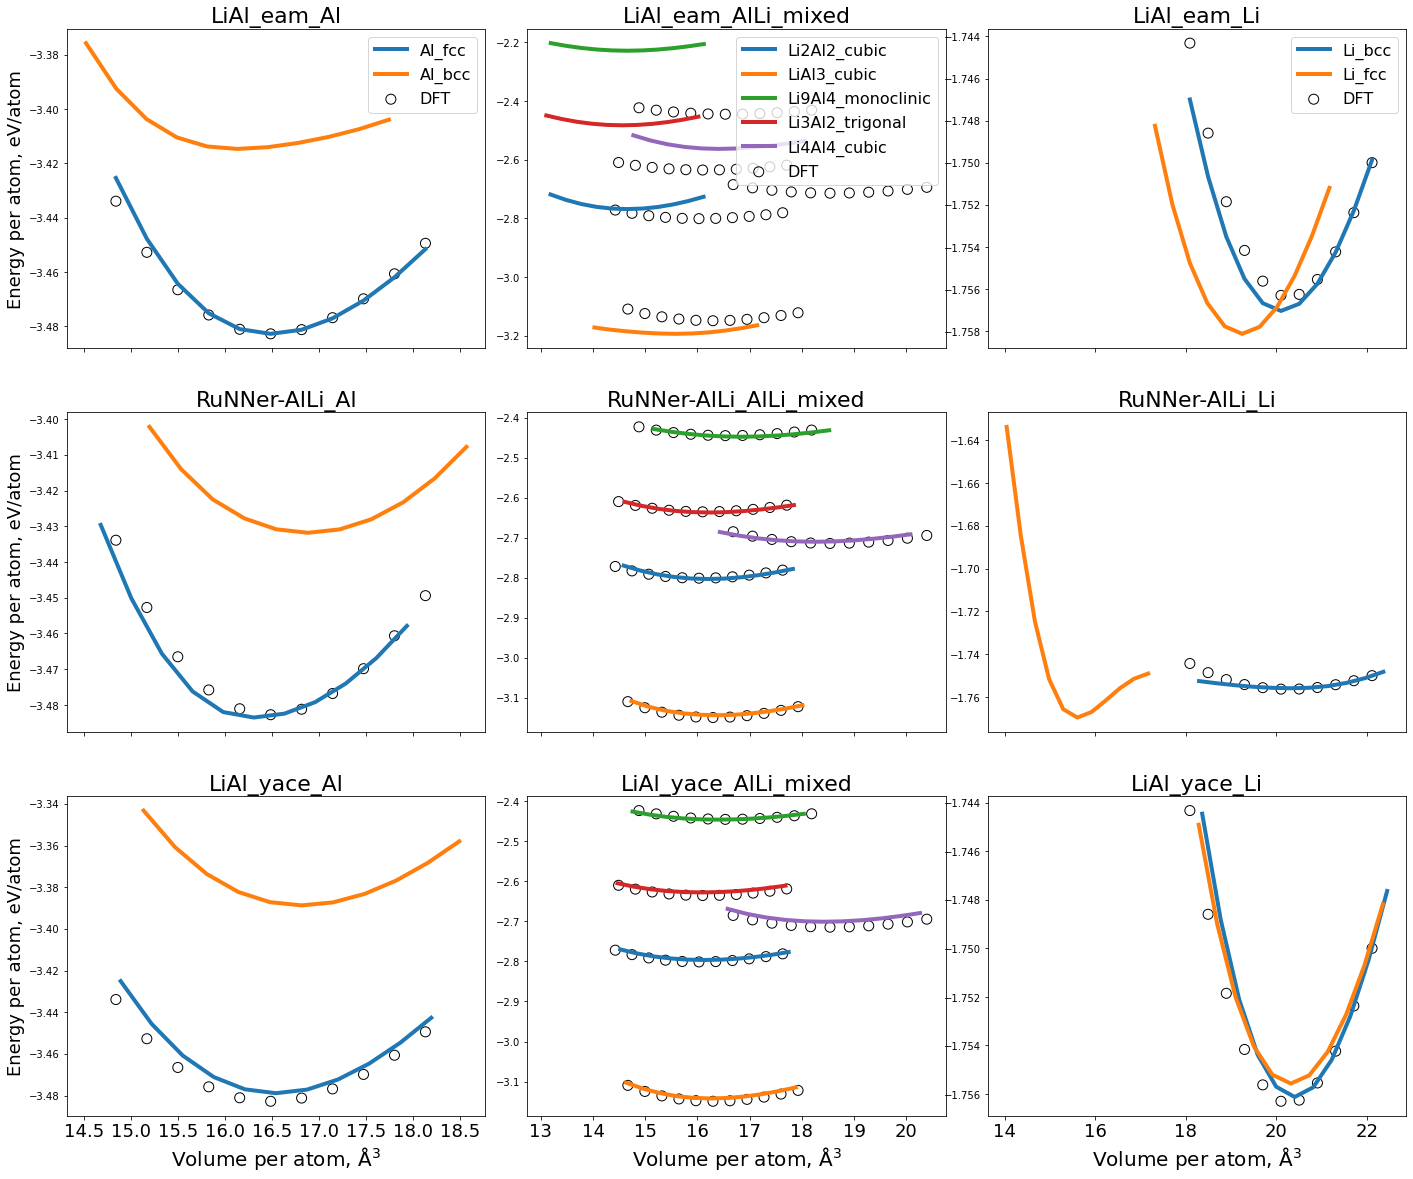

In [11]:
fig, ax_list = plt.subplots(ncols=3, nrows=len(potentials_list), sharex="col")

fig.set_figwidth(24)
fig.set_figheight(20)

color_palette = sns.color_palette("tab10", n_colors=len(data_murn.phase.unique()))


for i, pot in enumerate(potentials_list):
    
    
    mask1 = data_murn["compound"]=="Al"
    data1 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask1)]
    
    mask2 = data_murn["compound"]=="Li"
    data2 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask2)]
    
    mask3 = data_murn["compound"].isin(["Al","Li"])
    data3 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (~mask3)]

    for j,(_, row) in enumerate(data1.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]

        ax_list[i,0].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        
        
        ax_list[i,0].set_title(f"{get_clean_project_name(pot)}" + '_' + data1.iloc[0]["compound"],fontsize=22)
        # ax_list[i,0].legend(prop={"size":16})
        
    ax_list[i,0].scatter(al_fcc["vol"],al_fcc["energy"]/al_fcc["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
    for j,(_, row) in enumerate(data2.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]
        
        ax_list[i,2].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        
        
        ax_list[i,2].set_title(f"{get_clean_project_name(pot)}" + '_' + data2.iloc[0]["compound"],fontsize=22)
        # ax_list[i,2].legend(prop={"size":16})
        
    ax_list[i,2].scatter(li_bcc["vol"],li_bcc["energy"]/li_bcc["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
    for j,(_, row) in enumerate(data3.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]
        
        ax_list[i,1].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        ax_list[i,1].set_title(f"{get_clean_project_name(pot)}" + '_AlLi_mixed',fontsize=22)
        # ax_list[i,1].legend(prop={"size":16})
        
    ax_list[i,1].scatter(df_mixed["vol"],df_mixed["energy"]/df_mixed["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
        
for i in range(3):
    ax_list[0,i].legend(prop={"size":16})
    ax_list[-1,i].set_xlabel("Volume per atom, $\mathrm{\AA^3}$",fontsize=20)
    ax_list[-1,i].tick_params(axis="x",labelsize=18)
    
for i in range(len(potentials_list)):
    ax_list[i,0].set_ylabel("Energy per atom, eV/atom",fontsize=18)
    
    
    
# ax.legend(prop={"size":16})
# ax.set_ylabel("Energy per atom, eV/atom",fontsize=20)
#break
fig.subplots_adjust(wspace=0.1);

## (b) Elastic constants and Phonons

Pyiron also has job modules to calculate elastic constants and thermal properties using the quasi-harmonic approximation given by the `phonopy` package.

As in the previous task, we again loop over the defined potentials and then over the given structures.

Calculating elastic constants and thermal properties is considerably more expensive than calculating EV curves. Hence, it is useful to only calculate these properties for a subset of most important structures 

In [12]:
list_of_phases = ["Al_fcc","Li_bcc","Li2Al2_cubic","LiAl3_cubic"]

subset_murn = data_murn[data_murn["phase"].isin(list_of_phases)]
subset_murn

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc
11,1283,RuNNer-AlLi,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.211118,20.286595,8.517306,-1.755918,1,Li_bcc
13,1309,RuNNer-AlLi,"(Atom('Li', [4.509081801264686, 2.603319591757272, 1.8408249369278522], index=0), Atom('Li', [6.763622701898693, 3.90497938763465, 2.7612374053913604], index=1), Atom('Al', [-3.844724064520768e-12...",Li2Al2,cubic,6.376805,64.816143,57.934650,-11.212634,4,Li2Al2_cubic
14,1322,RuNNer-AlLi,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0154153406879987, 2.0154153406879987, 2.46817194592603e-16], index=1), Atom('Al', [2.0154153406879987, 1.234085972963015e-16, 2.015415340687998...",LiAl3,cubic,5.700455,65.403086,59.308440,-12.574696,4,LiAl3_cubic
18,1374,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.044553,16.541594,87.130427,-3.478909,1,Al_fcc
20,1400,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.216389,20.403222,15.823747,-1.756104,1,Li_bcc


In [13]:
for pot in potentials_list:
    group_name = get_clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    print(group_name)
    
    for _, row in subset_murn[subset_murn.potential==group_name].iterrows():
        job_id = row["job_id"]
        
        job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{row.compound}_{row.crystal_structure}")
        ref = pr_pot.load(job_id)
        job_ref.structure = ref.structure
        job_ref.potential = pot
        job_ref.calc_minimize()
        elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, f"elastic_job_{row.compound}_{row.crystal_structure}")
        elastic_job.input["eps_range"] = 0.05
        elastic_job.run()
        
        
        phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, f"phonopy_job_{row.compound}_{row.crystal_structure}")
        job_ref.calc_static()
        phonopy_job.run()

LiAl_eam
The job elastic_job_Al_fcc was saved and received the ID: 1491
The job s_e_0 was saved and received the ID: 1492
The job s_01_e_m0_05000 was saved and received the ID: 1493
The job s_01_e_m0_02500 was saved and received the ID: 1494
The job s_01_e_0_02500 was saved and received the ID: 1495
The job s_01_e_0_05000 was saved and received the ID: 1496
The job s_08_e_m0_05000 was saved and received the ID: 1497
The job s_08_e_m0_02500 was saved and received the ID: 1498
The job s_08_e_0_02500 was saved and received the ID: 1499
The job s_08_e_0_05000 was saved and received the ID: 1500
The job s_23_e_m0_05000 was saved and received the ID: 1501
The job s_23_e_m0_02500 was saved and received the ID: 1502
The job s_23_e_0_02500 was saved and received the ID: 1503
The job s_23_e_0_05000 was saved and received the ID: 1504
The job phonopy_job_Al_fcc was saved and received the ID: 1505
The job ref_job_Al_fcc_0 was saved and received the ID: 1506
The job elastic_job_Li_bcc was saved and

In [14]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [15]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic["phase"] = data_elastic.compound + "_" + data_elastic.crystal_structure
data_elastic = data_elastic[data_elastic["phase"].isin(list_of_phases)]
data_elastic

The job table_elastic was saved and received the ID: 1689


Loading and filtering jobs:   0%|          | 0/12 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/12 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure,phase
0,1491,LiAl_eam,120.339279,66.483631,45.515458,Al,fcc,Al_fcc
1,1507,LiAl_eam,16.740018,11.018163,12.688217,Li,bcc,Li_bcc
2,1523,LiAl_eam,179.464635,54.231219,47.889040,Li2Al2,cubic,Li2Al2_cubic
3,1540,LiAl_eam,65.443987,47.601166,28.002138,LiAl3,cubic,LiAl3_cubic
4,1557,RuNNer-AlLi,119.613688,59.261331,57.671025,Al,fcc,Al_fcc
5,1573,RuNNer-AlLi,13.974565,4.476591,13.293350,Li,bcc,Li_bcc
6,1589,RuNNer-AlLi,124.404880,20.665379,42.673693,Li2Al2,cubic,Li2Al2_cubic
7,1606,RuNNer-AlLi,88.575923,50.190830,48.202184,LiAl3,cubic,LiAl3_cubic
8,1623,LiAl_yace,133.807535,62.693651,40.423203,Al,fcc,Al_fcc
9,1639,LiAl_yace,18.307762,13.775557,12.106574,Li,bcc,Li_bcc


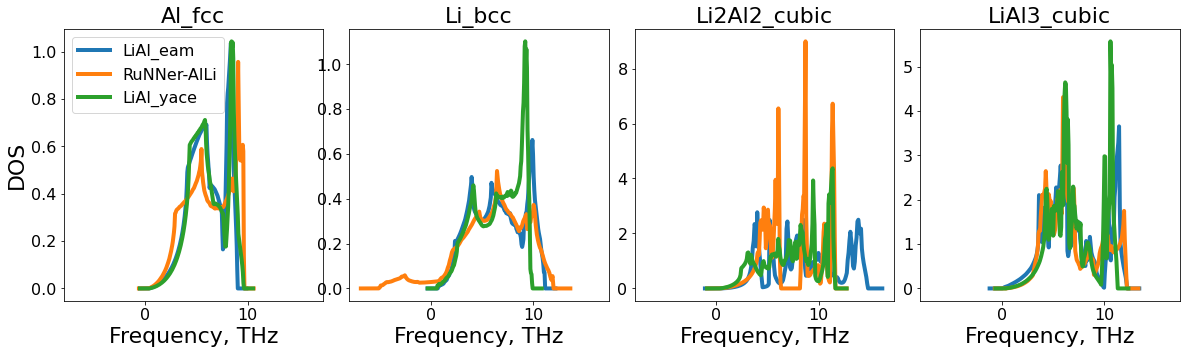

In [16]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))

pot = "LiAl_yace"


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    # data = data_elastic[(data_elastic.phase == phase) & (data_elastic["potential"]=="pot")]
    data = data_elastic[(data_elastic.phase == phase)]
    
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
        
        ax.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
                lw=4,
                color=color_palette[j], 
                label=get_clean_project_name(pot))
        ax.set_xlabel("Frequency, THz",fontsize=22)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("DOS",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

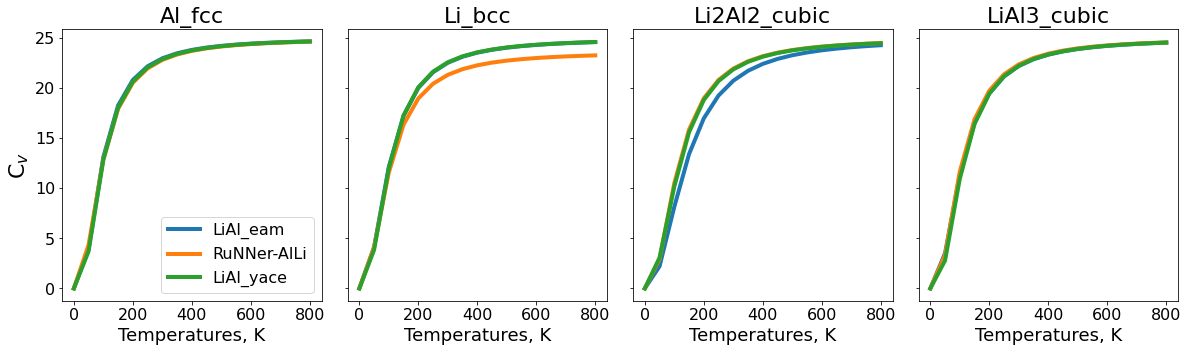

In [17]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    data = data_elastic[data_elastic.phase == phase]
    
    n_atom = data_murn[data_murn["phase"]==phase]["n_atoms"].iloc[0]
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)

        ax.plot(thermo.temperatures, thermo.cv/n_atom,
                lw=4,
                label=get_clean_project_name(pot), 
                color=color_palette[j])
        ax.set_xlabel("Temperatures, K",fontsize=18)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("C$_v$",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

In [18]:
# phonopy_job.plot_band_structure()

## (c) Convex hull

To assess the stability of the binary phases, we plot a convex hull for the considered phases. 

For this task we compute the formation energies of the mixed phases relative to ground state energies of equilibrium unary phases.

In [19]:
from collections import Counter

# pot = "LiAl_yace"

# data_convexhull = data_murn[data_murn["potential"]==pot]
data_convexhull = data_murn.copy()
data_convexhull.head(2)

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc


Using `Collections.counter` we construct a composition dictionary for all the phases and from that dictionary, we can extract the relative concentrations of Al and Li in each structure

Obtain the equilibrium energies for unary Al and Li phases from the Dataframe

Calculate the relative formation energies by subtracting the total energies of the mixed phases with the energies of eq Al and Li

$$E^{A_xB_y}_{f} = E_{A_xB_y} - (x E_A + yE_B)$$

Similarly calculate the formation energies from DFT ref data

In [20]:
def get_e_form(data_convexhull):
    data_convexhull["comp_dict"] = data_convexhull["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
    data_convexhull["n_Al"] = data_convexhull["comp_dict"].map(lambda d: d.get("Al",0))
    data_convexhull["n_Li"] = data_convexhull["comp_dict"].map(lambda d: d.get("Li",0))

    data_convexhull["cAl"]= data_convexhull["n_Al"]/data_convexhull["n_atoms"] * 100
    data_convexhull["cLi"]= data_convexhull["n_Li"]/data_convexhull["n_atoms"] * 100

    E_f_Al = data_convexhull.loc[data_convexhull["n_Li"]==0,"eq_energy"].min()
    E_f_Li = data_convexhull.loc[data_convexhull["n_Al"]==0,"eq_energy"].min()

    data_convexhull["E_form"]=(data_convexhull["eq_energy"])-(data_convexhull[["n_Al","n_Li"]].values * [E_f_Al, E_f_Li]).sum(axis=1)
    data_convexhull["E_form_per_atom"] = data_convexhull["E_form"]/data_convexhull["n_atoms"] * 1e3

    data_convexhull = data_convexhull.sort_values("cLi")

    return data_convexhull

df_eam = get_e_form(data_murn[data_murn["potential"]=="LiAl_eam"].copy())
mask = df_eam["compound"]=="Li9Al4"
df_eam = df_eam[~mask]
df_nnp = get_e_form(data_murn[data_murn["potential"]=="RuNNer-AlLi"].copy())
df_ace = get_e_form(data_murn[data_murn["potential"]=="LiAl_yace"].copy())

data_convexhull = pd.concat([df_eam,df_nnp,df_ace])
data_convexhull

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase,comp_dict,n_Al,n_Li,cAl,cLi,E_form,E_form_per_atom
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc,{'Al': 1},1,0,100.000000,0.000000,0.000000,0.000000
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc,{'Al': 1},1,0,100.000000,0.000000,0.067785,67.785186
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic,"{'Li': 1, 'Al': 3}",3,1,75.000000,25.000000,-0.567192,-141.797976
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic,"{'Li': 2, 'Al': 2}",2,2,50.000000,50.000000,-0.591954,-147.988453
8,1244,LiAl_eam,"(Atom('Li', [2.142967147985671, 1.2372426587287435, 7.662120717536293], index=0), Atom('Li', [-8.783761113500244e-10, 2.4744853189563414, 0.5913679335098909], index=1), Atom('Li', [-8.783761113500...",Li4Al4,cubic,6.061226,131.389799,71.221355,-20.506570,8,Li4Al4_cubic,"{'Li': 4, 'Al': 4}",4,4,50.000000,50.000000,0.458247,57.280860
7,1231,LiAl_eam,"(Atom('Al', [2.1548001975659234, 1.244075358781918, 1.861784175000869], index=0), Atom('Al', [-2.154798282819334, 3.732223313213554, 2.6646760238080542], index=1), Atom('Li', [8.560563403365654e-0...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal,"{'Al': 2, 'Li': 3}",2,3,40.000000,60.000000,-0.173341,-34.668107
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc,{'Li': 1},0,1,0.000000,100.000000,0.001096,1.096047
3,1179,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc,{'Li': 1},0,1,0.000000,100.000000,0.000000,0.000000
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc,{'Al': 1},1,0,100.000000,0.000000,0.000000,0.000000
10,1270,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.958447,16.870137,51.052272,-3.432183,1,Al_bcc,{'Al': 1},1,0,100.000000,0.000000,0.051832,51.832389


In [21]:
phases = ["Al_fcc","LiAl_mp-1067","LiAl3_mp-10890","Li9Al4_mp-568404","Li3Al2_mp-16506","LiAl_mp-1079240","Li_bcc"]

df_phases = df[df["compound"].isin(phases)]
convex_ref = df_phases.loc[df_phases.groupby('compound').energy.idxmin()]
convex_ref["comp_dict"] = convex_ref["ao"].map(lambda at: Counter(at.get_chemical_symbols()))
convex_ref["n_Al"] = convex_ref["comp_dict"].map(lambda d: d.get("Al",0))
convex_ref["n_Li"] = convex_ref["comp_dict"].map(lambda d: d.get("Li",0))

convex_ref["cAl"]= convex_ref["n_Al"]/convex_ref["number_of_atoms"] * 100
convex_ref["cLi"]= convex_ref["n_Li"]/convex_ref["number_of_atoms"] * 100


E_f_Al = convex_ref.loc[convex_ref["n_Li"]==0,"energy"].min()/convex_ref[convex_ref["compound"]=="Al_fcc"]["number_of_atoms"].item()
E_f_Li = convex_ref.loc[convex_ref["n_Al"]==0,"energy"].min()/convex_ref[convex_ref["compound"]=="Li_bcc"]["number_of_atoms"].item()

convex_ref["E_form"]=(convex_ref["energy"])-(convex_ref[["n_Al","n_Li"]].values * [E_f_Al, E_f_Li]).sum(axis=1)
convex_ref["E_form_per_atom"] = convex_ref["E_form"]/convex_ref["number_of_atoms"] * 1e3

convex_ref = convex_ref.sort_values("cLi")

# convex_ref

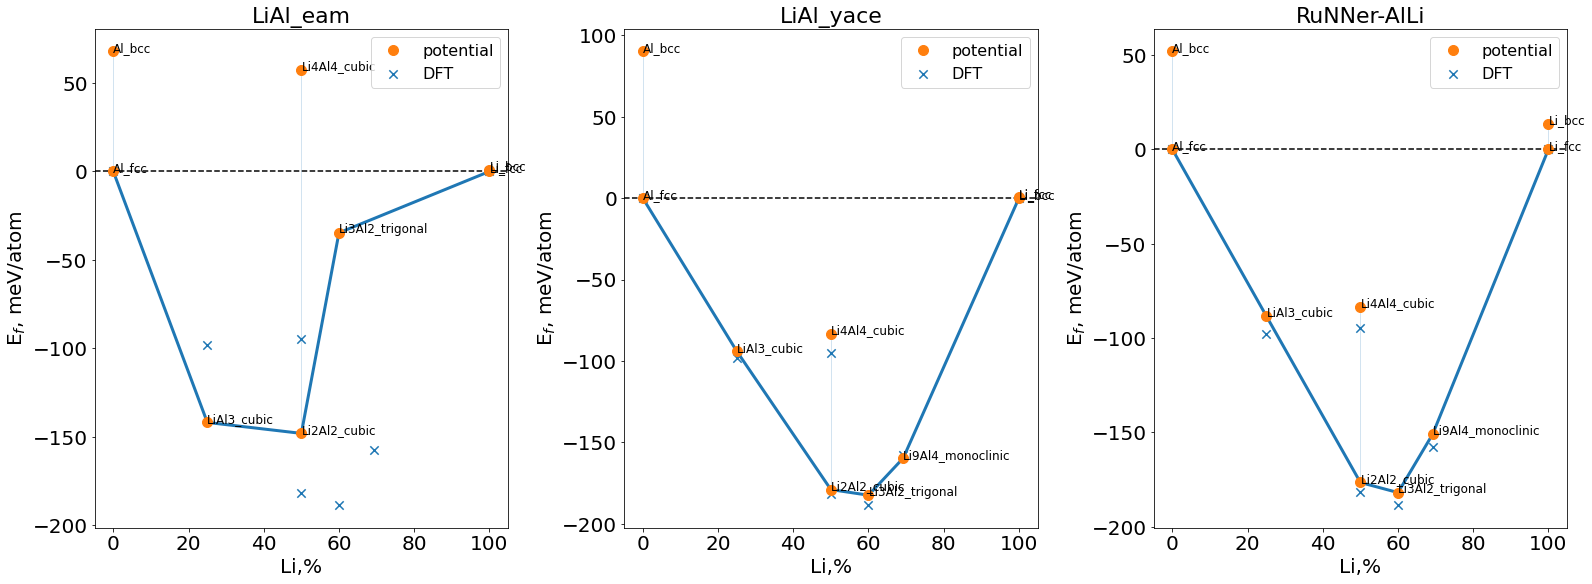

In [22]:
fig,ax = plt.subplots(figsize=(22,8),ncols=len(potentials_list),constrained_layout=True)

dfs = ([pd.DataFrame(y) for x, y in data_convexhull.groupby(by='potential', as_index=False)])

for i,pot in enumerate(potentials_list):
    sns.lineplot(data=dfs[i],
                 marker='o',
                 x='cLi', y='E_form_per_atom',
                 estimator=np.min,
                 ax=ax[i],lw=3)
    
    

    ax[i].axhline(0,ls="--",color="k")
    ax[i].plot(dfs[i]["cLi"], dfs[i]["E_form_per_atom"],"o",markersize=10,label="potential")
    ax[i].scatter(convex_ref["cLi"],convex_ref["E_form_per_atom"],marker="x",s=70,
                  label="DFT")
    ax[i].legend(prop={"size":16})
    ax[i].set_xlabel("Li,%",fontsize="20")
    ax[i].set_ylabel("E$_f$, meV/atom",fontsize="20")
    ax[i].tick_params(labelsize=20,axis="both")
# ax.set_ylim(-200,10)
    for _,row in dfs[i].iterrows():
        ax[i].text((row["cLi"]+0.01),row["E_form_per_atom"],row["phase"],size=12)
        
    ax[i].set_title(dfs[i].iloc[0]["potential"],fontsize=22)

plt.show()

In [23]:
time_stop = time.time()
print(f"Total run time for the notebook {time_stop - time_start} seconds")

Total run time for the notebook 572.1296255588531 seconds


In [25]:
572.1296255588531/60

9.53549375931422